## 1. Preparation 

In [1]:
from __future__ import print_function
import pickle
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

def get_values(SAMPLE_SPREADSHEET_ID, SAMPLE_RANGE_NAME):
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')
    
    return values

## 2.0 Read Spreasheets data

In [3]:
# Read attaquants
attaquants = get_values('14_yHHExaNXEjFIVRr_OBLtpiWPRjOS-e9TEca6N28xU', 'Attaquants')
attaquants = pd.DataFrame(attaquants[2:])
attaquants = attaquants.dropna(subset=[0,36]) # Drop if no name or nan cap hits
attaquants = attaquants[attaquants[36]!='']
attaquants['pos'] = 'A'

# Read defenseurs
defenseurs = get_values('14_yHHExaNXEjFIVRr_OBLtpiWPRjOS-e9TEca6N28xU', 'Defenseurs')
defenseurs = pd.DataFrame(defenseurs[2:])
defenseurs = defenseurs.dropna(subset=[0,36]) # Drop if no name or nan cap hits
defenseurs = defenseurs[defenseurs[36]!='']
defenseurs['pos'] = 'D'

# Read gardiens
gardiens = get_values('14_yHHExaNXEjFIVRr_OBLtpiWPRjOS-e9TEca6N28xU', 'Gardiens')
gardiens = pd.DataFrame(gardiens[1:])
gardiens = gardiens.dropna(subset=[0,21]) # Drop if no name or nan cap hits
gardiens['pos'] = 'G'

In [4]:
nhl = pd.concat([attaquants[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                 defenseurs[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                 gardiens[[1,2,'pos',12,21,22]].rename({1: 'name', 2: 'status', 12: 'proj', 21: 'cap_hit', 22: 'end'}, axis=1)],
                 ignore_index=True)
nhl['cap_hit'] = nhl['cap_hit'].replace(',', '', regex=True).astype(int)
nhl['proj'] = nhl['proj'].astype(int)
nhl = nhl[nhl.status != 'x']

## 3.0 Knapsack
https://medium.com/@kangeugine/fantasy-football-as-a-data-scientist-part-2-knapsack-problem-6b7083955e93

In [5]:
from pulp import *

player = [str(i) for i in range(nhl.shape[0])]
point = {str(i): int(nhl['proj'].iloc[i]) for i in range(nhl.shape[0])} 
cost = {str(i): int(nhl['cap_hit'].iloc[i]) for i in range(nhl.shape[0])}
att = {str(i): 1 if nhl['pos'].iloc[i] == 'A' else 0 for i in range(nhl.shape[0])}
defe = {str(i): 1 if nhl['pos'].iloc[i] == 'D' else 0 for i in range(nhl.shape[0])}
goal = {str(i): 1 if nhl['pos'].iloc[i] == 'G' else 0 for i in range(nhl.shape[0])}
xi = {str(i): 1 for i in range(nhl.shape[0])}

In [6]:
prob = LpProblem("Fantasy Hockey", LpMaximize)
player_vars = LpVariable.dicts("Players", player, cat=LpBinary)

In [7]:
# objective function
prob += lpSum([point[i] * player_vars[i] for i in player]), "Total Cost"

In [8]:
# constraint
prob += lpSum([player_vars[i] for i in player]) == 22, "Total 20 Players"
prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 81500000, "Total Cost"
prob += lpSum([att[i] * player_vars[i] for i in player]) <= 13, "Less than 13 att"
prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 7, "Less than 7 def"
prob += lpSum([goal[i] * player_vars[i] for i in player]) <= 2, "Less than 2 goalers"

In [9]:
%%time
# solve
status = prob.solve()

CPU times: user 19.7 ms, sys: 6.99 ms, total: 26.7 ms
Wall time: 132 ms


In [10]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

Status: Optimal


In [11]:
selection = {}
for v in prob.variables():
    index = int(v.name.split("_")[1])
    selection[index] = v.varValue
#     print(v.name, "=", v.varValue)

In [12]:
nhl['label'] = 0.0
nhl = nhl.reset_index()
for i in selection:
    nhl.loc[i, 'label'] = selection[i]

In [13]:
XI = nhl[nhl['label'] == 1.0]
TOTAL_POINTS = XI['proj'].sum()
TOTAL_COST = XI['cap_hit'].sum()
TOTAL_PLAYERS = XI.shape[0]
print("Total points: {}, cost: {}$, and with players: {}".format(TOTAL_POINTS, TOTAL_COST, TOTAL_PLAYERS))
(XI[['name','pos','proj','cap_hit', 'end']]
 .sort_values(['pos'])
 .reset_index(drop=True))

Total points: 1622, cost: 81413330$, and with players: 22


,name,pos,proj,cap_hit,end
0,Nikita Kucherov,A,110,9500000,27
1,Pierre-Luc Dubois,A,60,894166,20
2,Jack Hughes,A,62,925000,22
3,Alex DeBrincat,A,72,778333,20
4,Sean Couturier,A,75,4333333,22
5,Elias Pettersson,A,77,925000,21
6,Mathew Barzal,A,69,863333,20
7,Aleksander Barkov,A,90,5900000,22
8,David Pastrnak,A,91,6666666,23
9,Johnny Gaudreau,A,93,6750000,22


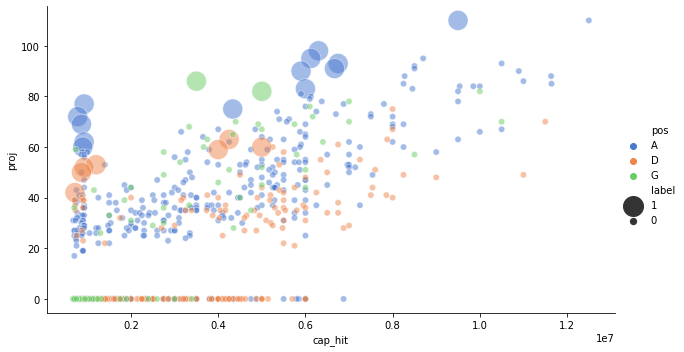

In [14]:
sns.relplot(x="cap_hit", y="proj", 
            hue="pos", size='label',
            size_order=[1,0],
            sizes=(40, 400), alpha=.5, 
            palette="muted", height=5, aspect=1.75,
            data=nhl)

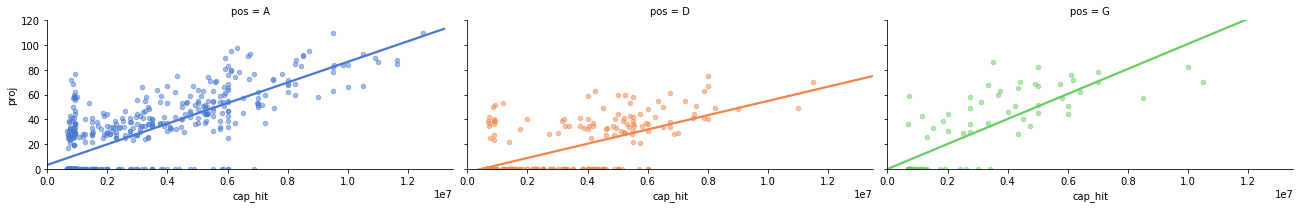

In [15]:
sns.lmplot(x="cap_hit", y="proj", col="pos", hue="pos", 
           data=nhl, aspect=2,
           col_wrap=4, ci=None, palette="muted", height=3,
#            hue_order=['DEF','GK','MID', 'STR'],
#            col_order=['DEF','GK','MID', 'STR'],
           scatter_kws={"s": 20, "alpha": 0.5})
plt.xlim(0, 1000000+max(nhl.cap_hit));
plt.ylim(0, 10+max(nhl.proj));

In [16]:
slope_inter = {}
for pos in np.unique(nhl.pos):
    pos_data = nhl[(nhl.pos == pos) & (nhl.proj >= 0)].reset_index(drop=True)
    output = linregress(pos_data['cap_hit'],pos_data['proj'])
    print("For {}, y = {:f}x + {:0.3f}".format(pos, 1000000*output.slope, output.intercept))
    slope_inter[pos] = {"slope":output.slope, "intercept":output.intercept}

For A, y = 8.330173x + 3.215
For D, y = 5.760900x + -2.679
For G, y = 10.112881x + -0.073


## 4.0 Script

In [32]:
from __future__ import print_function
import pickle
import os.path
import pandas as pd
import numpy as np
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from pulp import *


def get_values(SAMPLE_SPREADSHEET_ID, SAMPLE_RANGE_NAME):
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')
    
    return values


def get_selection(nhl):
    # Setup
    player = [str(i) for i in range(nhl.shape[0])]
    point = {str(i): int(nhl['proj'].iloc[i]) for i in range(nhl.shape[0])} 
    cost = {str(i): int(nhl['cap_hit'].iloc[i]) for i in range(nhl.shape[0])}
    end = {str(i): int(nhl['end'].iloc[i]) for i in range(nhl.shape[0])} 
    att = {str(i): 1 if nhl['pos'].iloc[i] == 'A' else 0 for i in range(nhl.shape[0])}
    defe = {str(i): 1 if nhl['pos'].iloc[i] == 'D' else 0 for i in range(nhl.shape[0])}
    goal = {str(i): 1 if nhl['pos'].iloc[i] == 'G' else 0 for i in range(nhl.shape[0])}
    xi = {str(i): 1 for i in range(nhl.shape[0])}
    prob = LpProblem("Fantasy Hockey", LpMaximize)
    player_vars = LpVariable.dicts("Players", player, cat=LpBinary)
    
    # Objective function
    prob += lpSum([point[i] * player_vars[i] for i in player]), "Total Cost"
    
    # Constraints
    spots_to_fill = 22 - nhl[nhl.status == 'o'].shape[0]
    prob += lpSum([player_vars[i] for i in player]) == spots_to_fill, "Total {spots_to_fill} Players"
    money_left = nhl[nhl.status == 'o']['cap_hit'].sum()
    prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 81500000 - money_left, "Total Cost"
    prob += lpSum([att[i] * player_vars[i] for i in player]) <= 13, "Less than 13 att"
    prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 7, "Less than 7 def"
    prob += lpSum([goal[i] * player_vars[i] for i in player]) <= 2, "Less than 2 goalers"
    
    # Solve
    status = prob.solve()
    
    # Selection
    selection = {}
    for v in prob.variables():
        index = int(v.name.split("_")[1])
        selection[index] = v.varValue
    nhl['label'] = 0.0
    nhl = nhl.reset_index()
    for i in selection:
        nhl.loc[i, 'label'] = selection[i]
        
    # Display
    XI = nhl[nhl['label'] == 1.0]
    TOTAL_POINTS = XI['proj'].sum()
    TOTAL_COST = XI['cap_hit'].sum()
    TOTAL_PLAYERS = XI.shape[0]
    '''
    TODO: Print current players, and players to add
    '''
    print("Total points: {}\ncost: {}\nplayers: {}".format(TOTAL_POINTS, TOTAL_COST, TOTAL_PLAYERS))
    print('---------------------------------------------')
    print(XI[['name','pos','proj','cap_hit', 'end']][XI['pos']=='A'].sort_values(['pos']).reset_index(drop=True))
    print('---------------------------------------------')
    print(XI[['name','pos','proj','cap_hit', 'end']][XI['pos']=='D'].sort_values(['pos']).reset_index(drop=True))
    print('---------------------------------------------')
    print(XI[['name','pos','proj','cap_hit', 'end']][XI['pos']=='G'].sort_values(['pos']).reset_index(drop=True))
    print('---------------------------------------------\n')

    return nhl, XI


def main():
    # Read attaquants
    attaquants = get_values('14_yHHExaNXEjFIVRr_OBLtpiWPRjOS-e9TEca6N28xU', 'Attaquants')
    attaquants = pd.DataFrame(attaquants[2:])
    attaquants = attaquants.dropna(subset=[0,36]) # Drop if no name or nan cap hits
    attaquants = attaquants[attaquants[36]!='']
    attaquants['pos'] = 'A'

    # Read defenseurs
    defenseurs = get_values('14_yHHExaNXEjFIVRr_OBLtpiWPRjOS-e9TEca6N28xU', 'Defenseurs')
    defenseurs = pd.DataFrame(defenseurs[2:])
    defenseurs = defenseurs.dropna(subset=[0,36]) # Drop if no name or nan cap hits
    defenseurs = defenseurs[defenseurs[36]!='']
    defenseurs['pos'] = 'D'

    # Read gardiens
    gardiens = get_values('14_yHHExaNXEjFIVRr_OBLtpiWPRjOS-e9TEca6N28xU', 'Gardiens')
    gardiens = pd.DataFrame(gardiens[1:])
    gardiens = gardiens.dropna(subset=[0,21]) # Drop if no name or nan cap hits
    gardiens['pos'] = 'G'
    
    # Preprocessing
    nhl = pd.concat([attaquants[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                     defenseurs[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                     gardiens[[1,2,'pos',12,21,22]].rename({1: 'name', 2: 'status', 12: 'proj', 21: 'cap_hit', 22: 'end'}, axis=1)],
                     ignore_index=True)
    nhl['cap_hit'] = nhl['cap_hit'].replace(',', '', regex=True).astype(int)
    nhl['proj'] = nhl['proj'].astype(int)
    nhl = nhl[nhl.status != 'x'] # Only look at available players
    
    # Knapsack 1st tier
    print('TIER 1\n')
    nhl_selection1, X1 = get_selection(nhl)
    X1['tier'] = 1
    
    # Knapsack 2nd tier
    nhl_selection1 = nhl_selection1[nhl_selection1.label == 0.0]
    nhl_selection1 = nhl_selection1.drop(['index'], axis=1)
    print('TIER 2\n')
    nhl_selection2, X2 = get_selection(nhl_selection1)
    X2['tier'] = 2
    
    # Knapsack 3rd tier
    nhl_selection2 = nhl_selection2[nhl_selection2.label == 0.0]
    nhl_selection2 = nhl_selection2.drop(['index'], axis=1)
    print('TIER 3\n')
    nhl_selection3, X3 = get_selection(nhl_selection2)
    X3['tier'] = 3
    
    # Knapsack 4th tier
    nhl_selection3 = nhl_selection3[nhl_selection3.label == 0.0]
    nhl_selection3 = nhl_selection3.drop(['index'], axis=1)
    print('TIER 4\n')
    nhl_selection4, X4 = get_selection(nhl_selection3)
    X4['tier'] = 4
    
    # Knapsack 5th tier
    nhl_selection4 = nhl_selection4[nhl_selection4.label == 0.0]
    nhl_selection4 = nhl_selection4.drop(['index'], axis=1)
    print('TIER 5\n')
    nhl_selection5, X5 = get_selection(nhl_selection4)
    X5['tier'] = 5
    
    # Knapsack 6th tier
    nhl_selection5 = nhl_selection5[nhl_selection5.label == 0.0]
    nhl_selection5 = nhl_selection5.drop(['index'], axis=1)
    print('TIER 6\n')
    nhl_selection6, X6 = get_selection(nhl_selection5)
    X6['tier'] = 6
    
    # Knapsack 7th tier
    nhl_selection6 = nhl_selection6[nhl_selection6.label == 0.0]
    nhl_selection6 = nhl_selection6.drop(['index'], axis=1)
    print('TIER 7\n')
    nhl_selection7, X7 = get_selection(nhl_selection6)
    X7['tier'] = 7
    
    # Knapsack 8th tier
    nhl_selection7 = nhl_selection7[nhl_selection7.label == 0.0]
    nhl_selection7 = nhl_selection7.drop(['index'], axis=1)
    print('TIER 8\n')
    nhl_selection8, X8 = get_selection(nhl_selection7)
    X8['tier'] = 8
    
    # Knapsack 9th tier
    nhl_selection8 = nhl_selection8[nhl_selection8.label == 0.0]
    nhl_selection8 = nhl_selection8.drop(['index'], axis=1)
    print('TIER 9\n')
    nhl_selection9, X9 = get_selection(nhl_selection8)
    X9['tier'] = 9
    
    # Knapsack 10th tier
    nhl_selection9 = nhl_selection9[nhl_selection9.label == 0.0]
    nhl_selection9 = nhl_selection9.drop(['index'], axis=1)
    print('TIER 10\n')
    nhl_selection10, X10 = get_selection(nhl_selection9)
    X10['tier'] = 10
    
    return X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 
        
if __name__ == '__main__':
    nhl_selection1, nhl_selection2, nhl_selection3, nhl_selection4, nhl_selection5, nhl_selection6, nhl_selection7, nhl_selection8, nhl_selection9, nhl_selection10 = main()

TIER 1

Total points: 1622
cost: 81413330
players: 22
---------------------------------------------
                 name pos  proj  cap_hit end
0     Nikita Kucherov   A   110  9500000  27
1    Nathan MacKinnon   A    98  6300000  23
2       Brad Marchand   A    95  6125000  25
3     Johnny Gaudreau   A    93  6750000  22
4      David Pastrnak   A    91  6666666  23
5   Aleksander Barkov   A    90  5900000  22
6         Taylor Hall   A    83  6000000  20
7    Elias Pettersson   A    77   925000  21
8      Sean Couturier   A    75  4333333  22
9      Alex DeBrincat   A    72   778333  20
10      Mathew Barzal   A    69   863333  20
11        Jack Hughes   A    62   925000  22
12  Pierre-Luc Dubois   A    60   894166  20
---------------------------------------------
              name pos  proj  cap_hit end
0   John Klingberg   D    63  4250000  22
1    Morgan Rielly   D    60  5000000  22
2       Roman Josi   D    59  4000000  20
3  Erik Gustafsson   D    53  1200000  20
4    Rasmus Da

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total points: 1417
cost: 81394165
players: 22
---------------------------------------------
                  name pos  proj   cap_hit end
0       Connor McDavid   A   110  12500000  26
1        Sidney Crosby   A    95   8700000  25
2       Leon Draisaitl   A    92   8500000  25
3       Steven Stamkos   A    91   8500000  24
4   Jonathan Huberdeau   A    81   5900000  23
5       Mark Scheifele   A    80   6125000  24
6             Max Domi   A    66   3150000  20
7          Kaapo Kakko   A    58    925000  22
8       Clayton Keller   A    58    885833  20
9         Kevin Labanc   A    58   1000000  20
10        Dylan Strome   A    57    863333  20
11       Nico Hischier   A    57    925000  20
12       Brady Tkachuk   A    56    925000  21
---------------------------------------------
             name pos  proj  cap_hit end
0     Brent Burns   D    75  8000000  25
1      Torey Krug   D    60  5250000  20
2      Cale Makar   D    40   880833  21
3  Miro Heiskanen   D    39   894166  21

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total points: 1290
cost: 81443290
players: 22
---------------------------------------------
                  name pos  proj  cap_hit end
0        Claude Giroux   A    88  8275000  22
1         Dylan Larkin   A    79  6100000  23
2         Sean Monahan   A    78  6375000  23
3        Jake Guentzel   A    76  6000000  24
4       Mika Zibanejad   A    74  5350000  22
5     Teuvo Teravainen   A    71  5400000  24
6      Evgenii Dadonov   A    67  4000000  20
7       Elias Lindholm   A    67  4850000  24
8         Sam Reinhart   A    64  3650000  20
9       Tyler Bertuzzi   A    53  1400000  20
10        Jake DeBrusk   A    50   863333  20
11   Andrei Svechnikov   A    47   925000  21
12  Jesperi Kotkaniemi   A    44   925000  21
---------------------------------------------
                  name pos  proj  cap_hit end
0        Mark Giordano   D    61  6750000  22
1         Tyson Barrie   D    58  5500000  20
2  Shayne Gostisbehere   D    49  4500000  23
3          Ryan Pulock   D    40  

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total points: 1184
cost: 81371706
players: 22
---------------------------------------------
                  name pos  proj  cap_hit end
0        Blake Wheeler   A    85  8250000  24
1     Patrice Bergeron   A    77  6875000  22
2    Alexander Radulov   A    74  6250000  22
3          Tomas Hertl   A    71  5625000  22
4    Gabriel Landeskog   A    70  5571429  21
5     Viktor Arvidsson   A    62  4250000  24
6       Rickard Rakell   A    59  3789444  22
7       Anthony Mantha   A    58  3300000  20
8   Andreas Athanasiou   A    56  3000000  20
9           Eric Staal   A    55  3250000  21
10        Jesper Bratt   A    43   749167  20
11         Roope Hintz   A    41   811667  20
12       Robert Thomas   A    41   894166  21
---------------------------------------------
                name pos  proj  cap_hit end
0         Seth Jones   D    53  5400000  22
1     Mattias Ekholm   D    41  3750000  22
2      Darnell Nurse   D    40  3200000  20
3     Josh Morrissey   D    39  3150000  2

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total points: 1106
cost: 81376498
players: 22
---------------------------------------------
                     name pos  proj  cap_hit end
0           Sebastian Aho   A    83  8454000  24
1       Nicklas Backstrom   A    73  6700000  20
2          Filip Forsberg   A    69  6000000  22
3   Jonathan Marchessault   A    64  5000000  24
4           Josh Anderson   A    45  1850000  20
5            Joe Thornton   A    44  2000000  20
6             Ryan Donato   A    43  1900000  21
7       Vinnie Hinostroza   A    41  1500000  20
8            Jared McCann   A    40  1250000  20
9             Max Comtois   A    39   820000  21
10        Anthony Cirelli   A    39   728333  20
11        Drake Batherson   A    38   736666  21
12          Dominik Kahun   A    37   925000  20
---------------------------------------------
              name pos  proj  cap_hit end
0     John Carlson   D    67  8000000  26
1    Victor Hedman   D    63  7875000  25
2     Keith Yandle   D    55  6350000  23
3      J

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total points: 1042
cost: 81403425
players: 22
---------------------------------------------
                 name pos  proj  cap_hit end
0    Evgeny Kuznetsov   A    77  7800000  25
1        Brock Boeser   A    66  5875000  22
2        Mike Hoffman   A    63  5187500  20
3           Bo Horvat   A    63  5500000  23
4    Vincent Trocheck   A    59  4750000  22
5   Brendan Gallagher   A    54  3750000  21
6        David Perron   A    53  4000000  22
7         Jakub Vrana   A    50  3350000  21
8         Ondrej Kase   A    47  2600000  21
9        Nick Ritchie   A    38  1498925  21
10      Nolan Patrick   A    36   925000  20
11     Oskar Lindblom   A    36   925000  20
12        Taro Hirose   A    36   925000  20
---------------------------------------------
               name pos  proj  cap_hit end
0        Matt Dumba   D    48  6000000  23
1     Zach Werenski   D    44  5000000  22
2    Charlie McAvoy   D    40  4900000  22
3     Oscar Klefbom   D    37  4167000  23
4      Will Butch

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total points: 999
cost: 81486665
players: 22
---------------------------------------------
                 name pos  proj   cap_hit end
0        Patrick Kane   A    93  10500000  23
1          Timo Meier   A    65   6000000  23
2      Brayden Schenn   A    59   5125000  20
3    Andreas Johnsson   A    48   3400000  23
4     Anthony Duclair   A    38   1650000  20
5     Victor Olofsson   A    34    767500  20
6           Sam Steel   A    33    863333  21
7          Tyson Jost   A    33    885833  20
8   Casey Mittelstadt   A    33    925000  20
9        Denis Malgin   A    32    750000  20
10      Brandon Pirri   A    32    775000  21
11     Lucas Wallmark   A    31    675000  20
12     Mathieu Joseph   A    31    728333  20
---------------------------------------------
                 name pos  proj  cap_hit end
0         Kris Letang   D    55  7250000  22
1    Alex Pietrangelo   D    50  6500000  20
2  Rasmus Ristolainen   D    43  5400000  22
3       Shea Theodore   D    41  520000

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total points: 947
cost: 81492064
players: 22
---------------------------------------------
                   name pos  proj  cap_hit end
0         Ryan O'Reilly   A    73  7500000  23
1   Ryan Nugent-Hopkins   A    64  6000000  21
2         Kyle Palmieri   A    54  4650000  21
3      Pavel Buchnevich   A    47  3250000  21
4       Kasperi Kapanen   A    46  3200000  22
5           Kevin Fiala   A    44  3000000  21
6    Oliver Bjorkstrand   A    41  2500000  21
7        Mark Jankowski   A    35  1675000  20
8           Corey Perry   A    33  1500000  21
9         Jack Roslovic   A    31   894166  20
10           Pat Maroon   A    31   900000  20
11         Brett Howden   A    30   863333  21
12    Christian Fischer   A    28   821666  20
---------------------------------------------
              name pos  proj  cap_hit end
0  Dougie Hamilton   D    44  5750000  21
1       Jeff Petry   D    42  5500000  21
2   Justin Schultz   D    39  5500000  20
3   Jared Spurgeon   D    39  5187500

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total points: 898
cost: 81474998
players: 22
---------------------------------------------
                  name pos  proj  cap_hit end
0   Vladimir Tarasenko   A    72  7500000  23
1     William Karlsson   A    61  5900000  27
2         Nikita Gusev   A    53  4500000  21
3        Chris Kreider   A    53  4625000  20
4      Phillip Danault   A    43  3083333  21
5           Zach Hyman   A    39  2250000  21
6        Frank Vatrano   A    39  2533333  22
7      Jordan Greenway   A    29   916666  20
8     Henrik Borgstrom   A    29   925000  20
9           Troy Terry   A    29   925000  20
10        Filip Chytil   A    28   894166  21
11     Brendan Leipsic   A    27   700000  20
12      Dylan Gambrell   A    27   700000  21
---------------------------------------------
               name pos  proj  cap_hit end
0  Dustin Byfuglien   D    51  7600000  21
1        Ryan Ellis   D    42  6250000  27
2    Colton Parayko   D    36  5500000  22
3     Jaccob Slavin   D    36  5300000  25
4   

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total points: 858
cost: 81472716
players: 22
---------------------------------------------
               name pos  proj  cap_hit end
0     Alex Ovechkin   A    84  9538462  21
1   Mikael Granlund   A    59  5750000  20
2      Reilly Smith   A    55  5000000  22
3    Jaden Schwartz   A    55  5350000  21
4     Chris Tierney   A    42  2937500  20
5        Erik Haula   A    41  2750000  20
6       Jimmy Vesey   A    36  2275000  20
7      Adrian Kempe   A    35  2000000  22
8   Carl Grundstrom   A    28   925000  20
9   Rudolfs Balcers   A    27   759167  20
10    Conor Garland   A    26   775000  21
11  Brendan Perlini   A    26   874125  20
12     Jason Spezza   A    25   700000  20
---------------------------------------------
              name pos  proj  cap_hit end
0     Nate Schmidt   D    37  5950000  25
1  Alexander Edler   D    36  6000000  21
2     Duncan Keith   D    35  5538462  20
3      Esa Lindell   D    35  5800000  25
4     Dmitry Orlov   D    31  5100000  23
5      Ry

/Users/noiseuce/miniconda3/envs/pool/lib/python3.6/site-packages/ipykernel_launcher.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
all_selections = pd.concat([nhl_selection1, nhl_selection2, nhl_selection3, nhl_selection4, nhl_selection5, nhl_selection6, nhl_selection7, nhl_selection8, nhl_selection9, nhl_selection10])
all_selections.to_csv('./all_selection.csv')